In [1]:
# Update Cell 0 imports to include regression metrics
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    # Classification metrics (for DecisionTreeClassifier)
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score,
    # Regression metrics (for RandomForestRegressor)
    mean_squared_error, mean_absolute_error, r2_score,
    mean_absolute_percentage_error, explained_variance_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_val_predict
import torch
from torch import nn
from tsai.basics import *
from tsai.inference import load_learner

/Users/interstellarobject/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
df = pd.read_csv('./data/data.csv')

In [3]:
df.head()

,date,avg_sentiment_score,open,high,low,close,volume,price_change,Bearish,Bullish,Neutral
0,2025-08-08,0.744132,117519.648438,117626.726562,116340.585938,116466.625000,6.314306e+10,-1053.023438,0,0,1
1,2025-08-05,0.709026,115072.187500,115117.437500,112701.109375,114141.445312,6.103918e+10,-930.742188,0,0,1
2,2025-08-04,0.725043,114223.921875,115729.468750,114130.406250,115071.882812,3.578303e+10,847.960938,0,0,1
3,2025-08-03,0.734659,112525.804688,114747.421875,111943.804688,114217.671875,4.809962e+10,1691.867188,0,0,1
4,2025-08-02,0.726161,113320.390625,114021.601562,112005.765625,112526.914062,5.687087e+10,-793.476562,0,0,1


In [4]:
# Cell 3 - Prepare data for time series forecasting
for col in df.columns:
        if col != 'date' and col != 'Bearish' and col != 'Bullish' and col != 'Neutral':
                df[col] = zscore(df[col])
display(df.head())

# Keep volume as target (we'll predict August 8, 2025 volume)
target_col = df['volume']
df = df.drop(columns=['volume', 'date'], axis=1)

# Now we need to create sequences for time series forecasting
def create_forecasting_sequences(data, target, lookback=30):
    """
    Create sequences where each sample uses 'lookback' days to predict the next day
    """
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences
lookback = 30  # Use last 30 days to predict next day
# X_sequences, y_sequences = create_forecasting_sequences(df.values, target_col.values, lookback)

# print(f"Sequences shape: {X_sequences.shape}")
# print(f"Targets shape: {y_sequences.shape}")

# # Split data - use all data up to August 7, 2025 for training
# # The last sequence will predict August 8, 2025
# train_size = len(X_sequences) - 1  # Keep last sequence for final prediction

# X_train = X_sequences[:train_size]
# y_train = y_sequences[:train_size]
# X_test = X_sequences[train_size:]  # This will be the sequence to predict August 8
# y_test = y_sequences[train_size:]  # This is the actual August 8 volume

# print(f"Training sequences: {X_train.shape}")
# print(f"Test sequence (for August 8): {X_test.shape}")

,date,avg_sentiment_score,open,high,low,close,volume,price_change,Bearish,Bullish,Neutral
0,2025-08-08,0.090693,1.839767,1.773043,1.869902,1.795967,1.255811,-0.667640,0,0,1
1,2025-08-05,-0.198437,1.751326,1.683695,1.736283,1.712025,1.161208,-0.597539,0,0,1
2,2025-08-04,-0.066524,1.720673,1.705488,1.788758,1.745615,0.025540,0.422151,0,0,1
3,2025-08-03,0.012674,1.659310,1.670520,1.708479,1.714777,0.579368,0.905943,0,0,1
4,2025-08-02,-0.057314,1.688024,1.644676,1.710754,1.653738,0.973776,-0.518848,0,0,1


In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
display(df.head())
# Convert to PyTorch tensors
# X_train_tensor = torch.FloatTensor(X_train).to(device)
# y_train_tensor = torch.FloatTensor(y_train).to(device)
# X_test_tensor = torch.FloatTensor(X_test).to(device)
# y_test_tensor = torch.FloatTensor(y_test).to(device)


# # LSTM model for time series forecasting
# class ForecastingLSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, lookback, dropout=0.4):
#         super(ForecastingLSTMModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lookback = lookback

#         self.lstm = nn.LSTM(
#             input_size=input_size,
#             hidden_size=hidden_size,
#             num_layers=num_layers,
#             batch_first=True,
#             dropout=dropout if num_layers > 1 else 0,
#         )

#         self.dropout = nn.Dropout(dropout)
#         self.fc = nn.Linear(hidden_size, 1)

#     def forward(self, x):
#         # x shape: (batch_size, lookback, features)
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

#         out, _ = self.lstm(x, (h0, c0))
#         out = self.dropout(out[:, -1, :])  # Use last timestep
#         out = self.fc(out)
#         return out.squeeze()


# # Create and train the model
# model_2 = ForecastingLSTMModel(
#     input_size=df.shape[1],
#     hidden_size=1024,
#     num_layers=8,
#     lookback=lookback,
#     dropout=0.2,
# ).to(device)

# criterion = nn.HuberLoss()
# optimizer = torch.optim.Adam(model_2.parameters(), lr=0.0001)

# # Training loop
# model_2.train()
# epochs = 200
# for epoch in range(epochs):
#     outputs = model_2(X_train_tensor)
#     loss = criterion(outputs, y_train_tensor)

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     if epoch % 20 == 0:
#         print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}")

Using device: mps


,avg_sentiment_score,open,high,low,close,price_change,Bearish,Bullish,Neutral
0,0.090693,1.839767,1.773043,1.869902,1.795967,-0.667640,0,0,1
1,-0.198437,1.751326,1.683695,1.736283,1.712025,-0.597539,0,0,1
2,-0.066524,1.720673,1.705488,1.788758,1.745615,0.422151,0,0,1
3,0.012674,1.659310,1.670520,1.708479,1.714777,0.905943,0,0,1
4,-0.057314,1.688024,1.644676,1.710754,1.653738,-0.518848,0,0,1


In [6]:
# # Make prediction for August 8, 2025
# model_2.eval()
# with torch.no_grad():
#     august_8_prediction = model_2(X_test_tensor).item()

# print("=== PREDICTION FOR AUGUST 8, 2025 ===")
# print(f"Predicted volume for August 8, 2025: {august_8_prediction:,.10f}")
# print(f"Actual volume for August 8, 2025: {y_test[0]:,.10f}")

# # Calculate prediction error
# prediction_error = abs(august_8_prediction - y_test[0])
# percentage_error = (prediction_error / y_test[0]) * 100

# print(f"Absolute error: {prediction_error:,.10f}")
# print(f"Percentage error: {percentage_error:.10f}%")

# # Compare with historical average
# historical_avg = np.mean(y_train)
# print(f"Historical average volume: {historical_avg:,.10f}")
# print(f"Prediction vs Historical avg: {((august_8_prediction - historical_avg) / historical_avg) * 100:.2f}%")

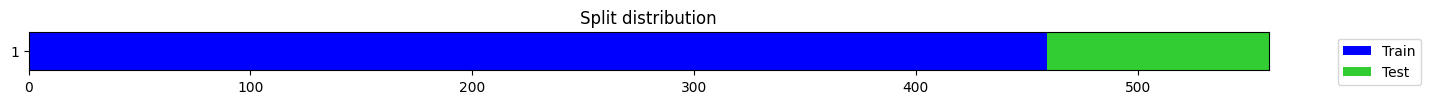

epoch,train_loss,valid_loss,mse,time
0,1.218045,0.663511,0.663511,00:01
1,0.892588,0.704866,0.704866,00:00
2,0.742983,0.994403,0.994403,00:00
3,0.649822,2.080404,2.080404,00:00
4,0.588088,0.966258,0.966258,00:00
5,0.561478,1.250204,1.250204,00:00
6,0.576444,1.194481,1.194481,00:00
7,0.650885,1.950830,1.950830,00:00
8,0.742173,1.647490,1.647490,00:00
9,0.925411,6.641985,6.641985,00:00


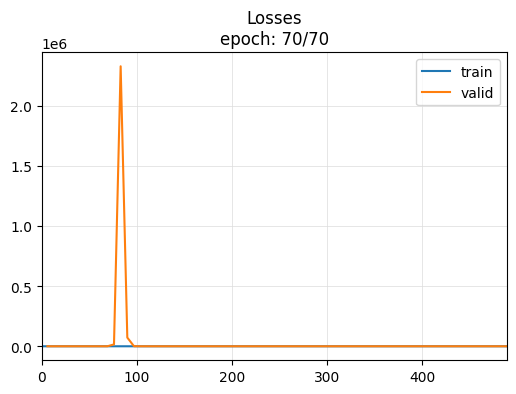

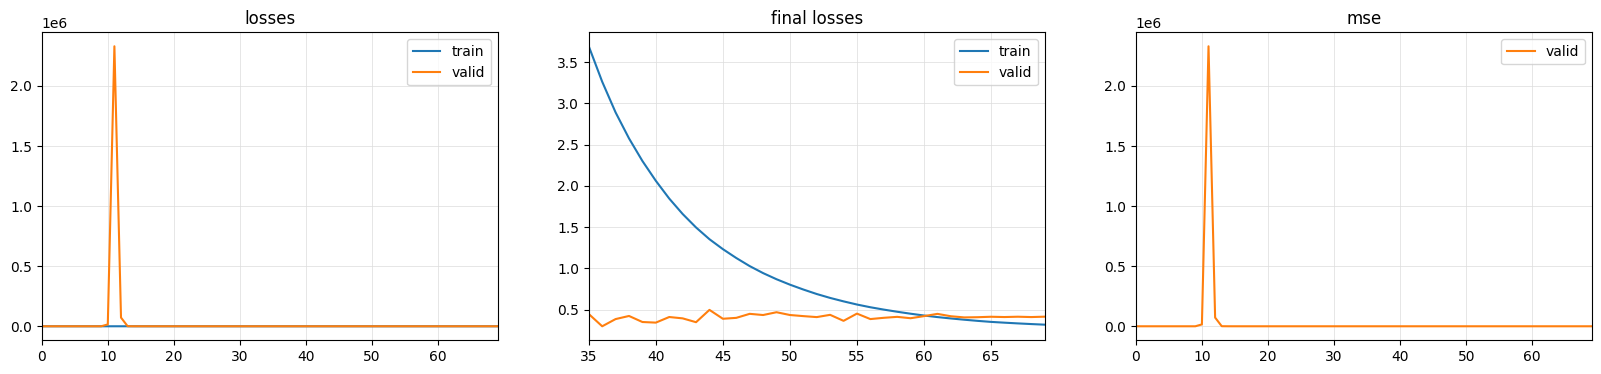

In [ ]:
x, y = SlidingWindow(
        90, horizon = 1
)(df)
splits = TimeSplitter(
        100    
)(y)
tfms = [None, TSForecasting()]
batch_tfms = None
fcst = TSForecaster(x, y, splits=splits, path='models', tfms=tfms, batch_tfms=batch_tfms, bs=64, arch="TSTPlus", metrics=mse, cbs=ShowGraph())
fcst.fit_one_cycle(70, 1e-3)
